Original opensees documentation link: https://opensees.berkeley.edu/wiki/index.php/Moment_Curvature_Example

moment-curvature analysis of a rectangular reinforced concrete section. In this example a Zero Length element with the fiber discretization of the cross section is used. 
<img src="https://opensees.berkeley.edu/wiki/images/5/5f/MomentCurvature.png"></img>


**Video regarding moment-curvature curve**: https://www.youtube.com/watch?v=FMXGwRN50dw

In [32]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt


## Section Definition

<img src="https://opensees.berkeley.edu/wiki/images/6/63/MomentCurvatureSection.png" align="left"></img>
<img src="https://opensees.berkeley.edu/wiki/images/0/08/MomentCurvatureSectionDiscritization.png" align="right"></img>


## section variables

In [33]:
#section parameters
d = 24 #inch
w = 15
cov = 1.5 #cover of unconfined concrete in inches
As  =  0.60    # area of no. 7 bars


concrete_coors_ext = [-d/2, w/2, -d/2, -w/2, d/2, -w/2,  d/2, w/2]

rebars_z = np.array([w/2-cov, 0., -w/2+cov])
rebars_y = np.array([d/2-cov, 0., -d/2+cov])

rebars_coors = []
for i,z in enumerate(rebars_z):
    for j,y in enumerate(rebars_y):
        if (z,y)!=(0,0):
            rebars_coors.append((z,y))


## Material properties

In [34]:
#material properties
#concrete
    #core concrete confined
core_conc = 1 #tag
fc_c = -6.0
ec0_c = -0.004
fcu_c = -5.0
ecu_c = -0.014

    #cover concrete unconfined
cover_conc = 2 #tag
fc_u = -5.0
ec0_u = -0.002
fcu_u = -0.0
ecu_u = -0.006

# STEEL
# Reinforcing steel 
steel = 3 #tag
fy =  60.0   # Yield stress
E =  30000.0  # Young's modulus
b = 0.01

In [35]:
def getSection(plotFiberSection = True):
    ops.wipe()
    ops.model("BasicBuilder", '-ndm', 2, '-ndf', 3)
                                        #tag   f'c        ec0   f'cu   ecu
    ops.uniaxialMaterial('Concrete01', core_conc, fc_c, ec0_c, fcu_c, ecu_c)
    ops.uniaxialMaterial('Concrete01', cover_conc, fc_u, ec0_u, fcu_u, ecu_u)
    ops.uniaxialMaterial('Steel01', steel, fy, E, b)

    ops.section('Fiber', 1)
    # Create the concrete core fibers
    #patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)
    numSubdivY = 10
    numSubdivZ = 1
    ops.patch('rect', core_conc, numSubdivY, numSubdivZ, *[d/2-cov, w/2-cov, -d/2+cov, -w/2+cov]) #core

    #cover concrete
    #+y, +y, +z, -z
    ops.patch('rect', cover_conc, 2, 1,*[d/2, w/2-cov, d/2-cov, -w/2+cov]) #top cover
    ops.patch('rect', cover_conc, 2, 1, *[-d/2+cov, w/2-cov, -d/2, -w/2+cov]) #bot cover
    ops.patch('rect', cover_conc, 10, 1, *[d/2 , -w/2+cov, -d/2, -w/2]) #right cover
    ops.patch('rect', cover_conc, 10, 1, *[d/2, w/2, -d/2, w/2-cov]) #left cover

    #layer('straight', matTag, numFiber, areaFiber, *start, *end)
    #top bottom mid
    ops.layer('straight', steel, 3, As, *[d/2-cov, w/2-cov], *[ d/2-cov, -w/2+cov])
    ops.layer('straight', steel, 3, As, *[-d/2+cov, w/2-cov,], *[-d/2+cov, -w/2+cov])
    ops.layer('straight', steel, 2, As, *[0, w/2-cov], *[0, -w/2+cov])    

    if plotFiberSection:
        fib_sec_list = [['section', 'Fiber', 1],
                        ['patch', 'rect', core_conc, numSubdivY, numSubdivZ, *[d/2-cov, w/2-cov, -d/2+cov, -w/2+cov]], #core
                        ['patch', 'rect', cover_conc, 2, 1, *[d/2, w/2-cov, d/2-cov, -w/2+cov]], #top
                        ['patch', 'rect', cover_conc, 2, 1, *[-d/2+cov, w/2-cov, -d/2, -w/2+cov]], #bot
                        ['patch', 'rect', cover_conc, 10, 1, *[d/2 , -w/2+cov, -d/2, -w/2]], #right cover
                        ['patch', 'rect', cover_conc, 10, 1, *[d/2, w/2, -d/2, w/2-cov]], #left cover
                            ['layer', 'straight', steel, 3, As, *[d/2-cov, w/2-cov], *[ d/2-cov, -w/2+cov]],
                            ['layer', 'straight', steel, 3, As, *[-d/2+cov, w/2-cov,], *[-d/2+cov, -w/2+cov]],
                            ['layer', 'straight', steel, 2, As, *[0, w/2-cov], *[0, -w/2+cov]],
                       ]
        matcolor = ['lightgrey', 'lightgrey', 'gold', 'w', 'w', 'w']
        ovs.plot_fiber_section(fib_sec_list, matcolor=matcolor)
        plt.axis('equal')

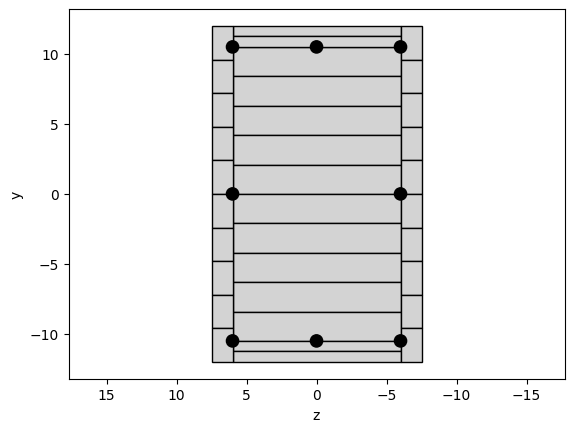

In [36]:
getSection(plotFiberSection = True)

In [47]:
def MomentCurvature(secTag, axialLoad, maxK, numIncr = 1000):
    #we will use zero length element to model the section for moment curvature analysis
    #so define two nodes at 0, 0
    ops.node(1, 0, 0)
    ops.node(2, 0, 0)
    
    # Fix all degrees of freedom except axial and bending
    ops.fix(1, 1, 1, 1)
    ops.fix(2, 0, 1, 0)
    
    #define element
    #element('zeroLength', eleTag, *eleNodes, '-mat', *matTags, '-dir', *dirs, <'-doRayleigh', rFlag=0>, <'-orient', *vecx, *vecyp>)
    ops.element('zeroLengthSection', 1, *[1,2], secTag) 

    #for curvature analysis
    conTS = 1
    linTS = 2
    
    ops.timeSeries('Constant', conTS)
    ops.pattern('Plain', 1, conTS)
    ops.load(2, *[axialLoad, 0, 0])
    
    #define recorders:
	# Define analysis parameters
    ops.integrator('LoadControl', 0.0)
    ops.system('SparseGeneral', '-piv')	# Overkill, but may need the pivoting!
    ops.test('NormUnbalance', 1.0e-9, 10)
    ops.numberer ('Plain')
    ops.constraints ('Plain')
    ops.algorithm ('Newton')
    ops.analysis ('Static')
    
    # Do one analysis for constant axial load
    ops.analyze(1)

    # Create recorder
    ops.recorder('Node', '-file', f'section{secTag}.txt', '-time', '-closeOnWrite',  '-node', 2, '-dof ', 3, 'disp')
    
    #define refrence moment
    ops.timeSeries('Linear', linTS)
    ops.pattern('Plain', 2, linTS)
    ops.load(2, *[0, 0, 1.0])
    
    #compute curvature increment steps
    dk = maxK / numIncr
    # Use displacement control at node 2 for section analysis
    #integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
    ops.integrator('DisplacementControl', 2, 3, dk)

    ops.record()
    for i in range(numIncr):
        ops.analyze(1)
        print(ops.nodeUnbalance(2, 3), ops.getTime())

# Analysis

In [48]:
# Estimate yield curvature
# (Assuming no axial load and only top and bottom steel)
# d -- from cover to rebar
dcr = d-cov
# steel yield strain
epsy = fy/E
Ky = epsy/(0.7*dcr) #ky is estimated yield curvature
Ky

0.000126984126984127

In [49]:
# Set axial load 
P = -180.0

# Target ductility for analysis
mu = 15.0

# Number of analysis increments
numIncr = 100 

1245.3025376555206 1245.3025376555206
1809.5076756726423 1809.5076756726423
2250.686274507143 2250.686274507143
2658.2403186126658 2658.2403186126658
3052.583779725404 3052.583779725404
3441.3189161623795 3441.3189161623795
3820.8808656105853 3820.8808656105853
4058.7861962020565 4058.7861962020565
4136.328151037155 4136.328151037155
4212.591739236375 4212.591739236375
4287.52674249006 4287.52674249006
4361.079305347468 4361.079305347468
4433.188430388451 4433.188430388451
4503.615080661115 4503.615080661115
4566.435900705584 4566.435900705584
4628.143287609268 4628.143287609268
4688.680331051974 4688.680331051974
4746.955724763391 4746.955724763391
4771.712888082872 4771.712888082872
4783.5320915716175 4783.5320915716175
4792.994833004024 4792.994833004024
4802.294431191571 4802.294431191571
4811.426340126653 4811.426340126653
4819.233433641591 4819.233433641591
4825.999551744126 4825.999551744126
4832.7559243881815 4832.7559243881815
4839.502486338366 4839.502486338366
4840.275013256

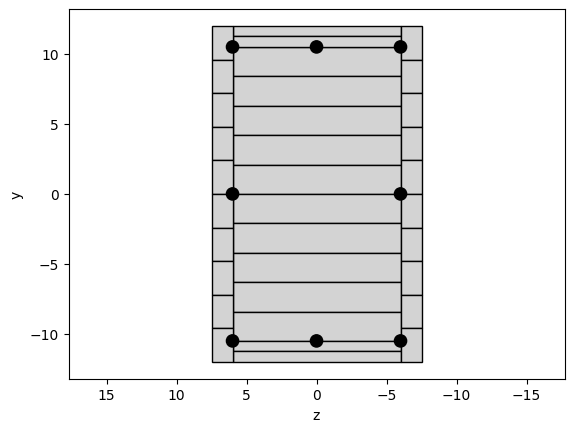

In [50]:
getSection()
# Call the section analysis procedure
MomentCurvature(1, P, Ky*mu, numIncr)

In [51]:
u = ops.nodeDisp(2,3)
if abs(u-0.00190476190476190541)<1e-12:
    print("Passed!")
else:
    print("Failed!")

Passed!


In [52]:
data = np.loadtxt("section1.txt", delimiter=" ")
data

array([[ 0.00000e+00, -1.09630e-21],
       [ 1.24530e+03,  1.90476e-05],
       [ 1.80951e+03,  3.80952e-05],
       [ 2.25069e+03,  5.71429e-05],
       [ 2.65824e+03,  7.61905e-05],
       [ 3.05258e+03,  9.52381e-05],
       [ 3.44132e+03,  1.14286e-04],
       [ 3.82088e+03,  1.33333e-04],
       [ 4.05879e+03,  1.52381e-04],
       [ 4.13633e+03,  1.71429e-04],
       [ 4.21259e+03,  1.90476e-04],
       [ 4.28753e+03,  2.09524e-04],
       [ 4.36108e+03,  2.28571e-04],
       [ 4.43319e+03,  2.47619e-04],
       [ 4.50362e+03,  2.66667e-04],
       [ 4.56644e+03,  2.85714e-04],
       [ 4.62814e+03,  3.04762e-04],
       [ 4.68868e+03,  3.23810e-04],
       [ 4.74696e+03,  3.42857e-04],
       [ 4.77171e+03,  3.61905e-04],
       [ 4.78353e+03,  3.80952e-04],
       [ 4.79299e+03,  4.00000e-04],
       [ 4.80229e+03,  4.19048e-04],
       [ 4.81143e+03,  4.38095e-04],
       [ 4.81923e+03,  4.57143e-04],
       [ 4.82600e+03,  4.76190e-04],
       [ 4.83276e+03,  4.95238e-04],
 

Text(0, 0.5, 'Moment')

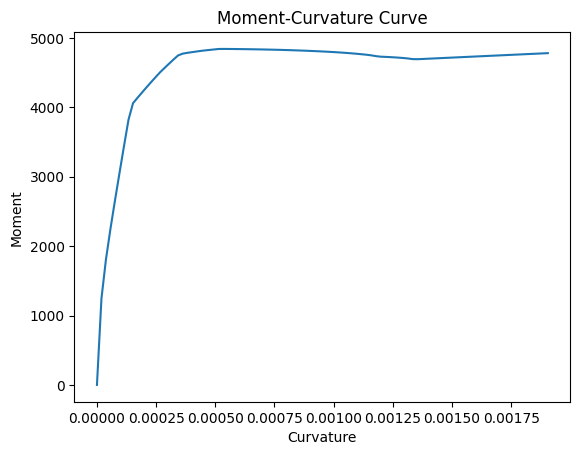

In [53]:
plt.plot(data[:, 1], data[:, 0])
plt.title("Moment-Curvature Curve")
plt.xlabel("Curvature")
plt.ylabel("Moment")